In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

!pip install pokebase
import pokebase as pb

# Import our helper libraries
import numpy as np
import scipy.stats as stat
import pandas as pd
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Question

Can we predict that a pokemon's attack will increase in tandem with its speed? That is, for each increment in speed, will there also be an increment in attack? 

The first step is to create a dataframe for the base-stats of each pokemon we're interested in (for us this will be the first 3 generations, or the first 386 pokemon, since all pokemon beyond this point are not nearly as cool as the first 3 generations - it will also slightly reduce the load on the pokeapi and save us a bit of time processing the data). We'll be using the pokebase wrapper.

In [ ]:
base_stats = []
i = 0
while i < 386:
  i += 1
  pokemonlist = pb.pokemon(i)
  base_stats.append([stat.base_stat for stat in pokemonlist.stats])

stats =pd.DataFrame(base_stats,columns=['hp','attack','defense','special_attack','special_defense', 'speed'])
stats


,hp,attack,defense,special_attack,special_defense,speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,39,52,43,60,50,65
4,58,64,58,80,65,80
...,...,...,...,...,...,...
381,100,100,90,150,140,90
382,100,150,140,100,90,90
383,105,150,90,150,90,95
384,100,100,100,100,100,100


Ok, that took a hot minute but we now have our dataframe of our pokemon base stats. Next we will create another dataframe with the names of our pokemon, among other identifying features like weight and height. 

We'll plan on this second dataframe to also take a few minutes to populate. 

In [ ]:
x=0
result=[]
while x < 386:
    x += 1
    url_stat = "https://pokeapi.co/api/v2/pokemon/" + str (x)
    response_stat = requests.get(url_stat)
    pokelist= pd.json_normalize(json.loads(response_stat.text))[['id','name','height','weight','base_experience']].values.tolist()[0]
    result.append(pokelist)

names =pd.DataFrame(result,columns=['id','name','height','weight','base_experience'])
names

,id,name,height,weight,base_experience
0,1,bulbasaur,7,69,64
1,2,ivysaur,10,130,142
2,3,venusaur,20,1000,263
3,4,charmander,6,85,62
4,5,charmeleon,11,190,142
...,...,...,...,...,...
381,382,kyogre,45,3520,335
382,383,groudon,35,9500,335
383,384,rayquaza,70,2065,340
384,385,jirachi,3,11,300


Great, looks good. Now we just need to join the two dataframes together to create our master dataframe. This will hold all the data we'll need for our primary question, plus some additional entries for the sake of creating a better dataframe to come back to in the future.  

In [ ]:
df = pd.concat([names, stats], axis=1, join='inner')
df

,id,name,height,weight,base_experience,hp,attack,defense,special_attack,special_defense,speed
0,1,bulbasaur,7,69,64,45,49,49,65,65,45
1,2,ivysaur,10,130,142,60,62,63,80,80,60
2,3,venusaur,20,1000,263,80,82,83,100,100,80
3,4,charmander,6,85,62,39,52,43,60,50,65
4,5,charmeleon,11,190,142,58,64,58,80,65,80
...,...,...,...,...,...,...,...,...,...,...,...
381,382,kyogre,45,3520,335,100,100,90,150,140,90
382,383,groudon,35,9500,335,100,150,140,100,90,90
383,384,rayquaza,70,2065,340,105,150,90,150,90,95
384,385,jirachi,3,11,300,100,100,100,100,100,100


Now we will check our two variables, attack and speed, to confirm that they are linear.

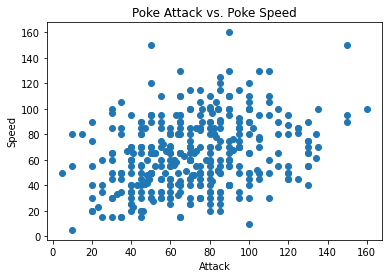

In [ ]:
plt.scatter(df.attack, df.speed)
plt.title('Poke Attack vs. Poke Speed')
plt.xlabel('Attack')
plt.ylabel('Speed')
plt.show()

In [ ]:
shapiro(df.attack)

(0.9888943433761597, 0.004953997675329447)

In [ ]:
shapiro(df.speed)

(0.9830639362335205, 0.00017082554404623806)

Ahh, the relationship does appear to be linear-ish? There's definitely a wide berth, but I'd argue it still trends linear considering the top left and bottom right of the plot. 

Indiviually they are definitely linear, so thats good.

Lets check some boxplots and see if we have any clear outliers that can be removed to improve this plot.

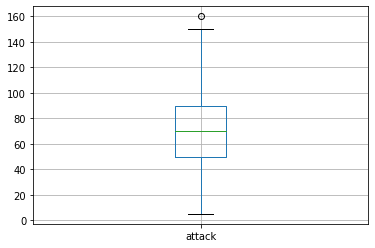

In [ ]:
df.boxplot(column = ['attack'])

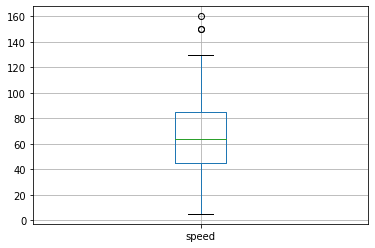

In [ ]:
df.boxplot(column = ['speed'])

Looks like we have at least 3 outliers, lets try to improve our linear relationship by removing them.

We will do so by removing all variables that lie beyond our z score range of an absolute value of 3

In [ ]:
attacknspeed = df.drop(['name', 'height', 'weight', 'base_experience', 'hp', 'defense', 'special_attack', 'special_defense'], axis = 1)

#find absolute value of z-score for each observation
z = np.abs(stat.zscore(attacknspeed))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
data_clean = attacknspeed[(z<3).all(axis=1)]

#find how many rows are left in the dataframe 
data_clean.shape

(382, 3)

We still have most of our pokemon, having only removed 4 outliers. Our boxplots should now be happier with us.

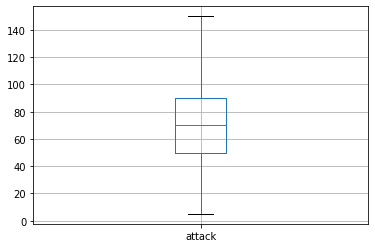

In [ ]:
data_clean.boxplot(column = ['attack'])

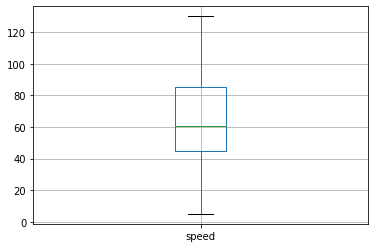

In [ ]:
data_clean.boxplot(column = ['speed'])

Great, looks good. Let's check the scatterplot again.

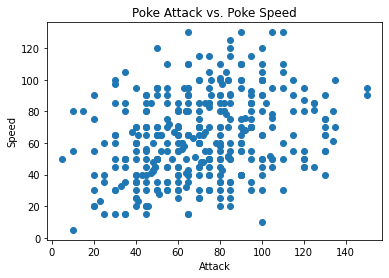

In [ ]:
plt.scatter(data_clean.attack, data_clean.speed)
plt.title('Poke Attack vs. Poke Speed')
plt.xlabel('Attack')
plt.ylabel('Speed')
plt.show()

Agh, still a globby mess - though a more concise one. I'm still leaning on it being somewhat linear, so lets continue with our linear regression and see what it tells us. 

In [ ]:
#define response variable
y = data_clean['attack']

#define explanatory variable
x = data_clean[['speed']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 attack   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     34.94
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           7.57e-09
Time:                        21:19:03   Log-Likelihood:                -1797.1
No. Observations:                 382   AIC:                             3598.
Df Residuals:                     380   BIC:                             3606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.5645      3.617     14.256      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Okay, since only 8.4% of the variation in attack can be attributed to speed (looking at the R-squared value), we can say that the primary driver of an increase in attack is probably not speed. Though when it vaguely has an affect, every increase in speed might lead to a ~.31 increase in attack. 

Now let's look at some residual plots to check our assumptions.

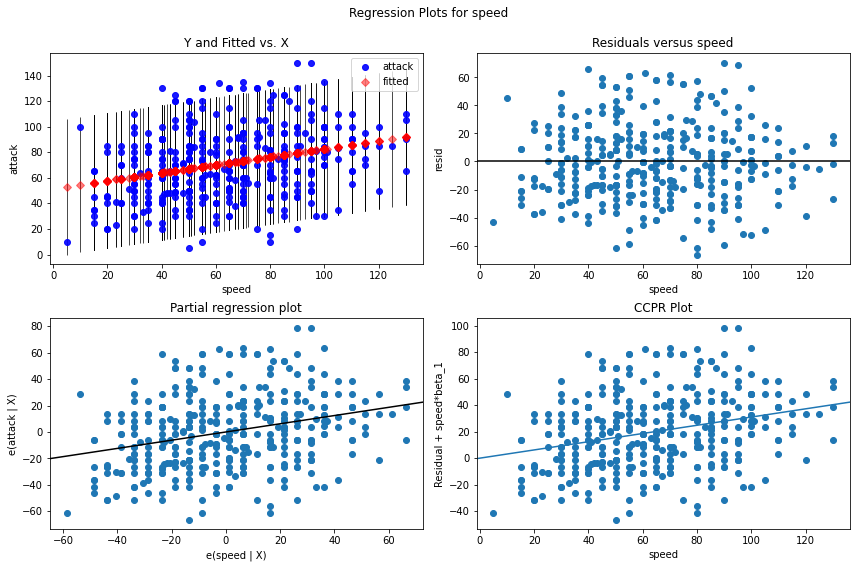

In [ ]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce residual plots
fig = sm.graphics.plot_regress_exog(model, 'speed', fig=fig)

Top right plot looks great (everything is scattered around 0, so heteroscedasticity is not a problem). 

The other three do technically have a diagonal line from lower left to upper right, but the slope isn't all that steep. 

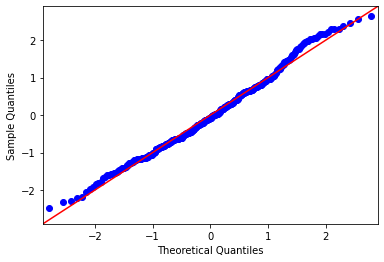

In [ ]:
#define residuals
res = model.resid

#create Q-Q plot
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 

Checking a QQ plot shows us that the residuals still mostly follow a normal distribution. It does stray from the line a little bit, but I don't think its enough to cause grave concern. 

#Write Up

(Used a speech to text for this summary, apologies in advance!)

I chose the Pokémon data set an API because I thought it would be easier to use rather than do a web crawler and it also gave me a bit of a nostalgic kick since I used to play these games as a kid. The question I wanted to ask, something that always bothered me, was how correlated or how related is attack and speed if my attack goes up does that mean my speed automatically goes up or if my speed goes up is that mean my attacks automatically going up how can I answer this question. To do so I decided to use a linear regression just a simple linear regression. Pulling the data from the APR. Pulling the data from the pokey API was pretty straightforward. There wasn’t much of a challenge here, all I needed to do is extract the Pokémon names and basic stats and then make that a data frame. The API didn’t have a full singular list, so I ended up making two data frames and concatenating them together. I decided to concatenate the data frame that had more variables than we were going to use, but I figured it is better just to make it a more “complete data frame and then event that I might look at this data again at a later time. Pulling from the data frame I only did the first three generations of Pokémon so that it would be easier on the API, and that it would save a little bit more time hauling the information. The first pole took about seven minutes for some reason and I can’t even imagine how long that would’ve taken with all the Pokémon I think there’s like 1000. Breaking it down to just attack and speed, I checked that each variable was linear in its own right with a Shapiro test. Those both checked out, however, the scatterplot was a little bit wide. I don’t know if it is a real linear plot it seems to be. It tends to trend upward and if you look in the upper left and lower right of the box plot they’re somewhat empty with white space whereas most of it does very generally trend from the bottom left to the upper right. So it is not nearly as concise as I would like. I figured it was probably OK to continue moving forward. Checked the box plots for each variable, then removed the outliers. I saw that there were three outliers, and with the Z test, we were able to remove four outliers. It didn’t do too much as far as improving the scatterplot, but at least some of the major outliers were no longer going to be a factor in our data. At this point now that we were as clean as we could be, I did the linear regression. Looking at the linear regression, it was clear to see that R-squared was very low. This tells me right off the bat that speed is not gonna have a very strong relationship with the attack. That relationship is only about 8%, and beyond that, if speed increases by one attacks on the increasing by .3 when there is a relation. Which is only 8% of the time. So as far as interpreting these results, There’s not much of a relationship between attack and speed. Beyond the regression, did double-check the residuals. They mostly looked OK. However, the linearity well it was trending from the bottom left upper right it wasn’t as sharp of a slope as I would have liked. I don’t know if this means it’s not linear, or if that means it’s just linear but not exclusively linear if that makes any sense. Maybe you could help clarify that for me. Our QQ plot did look mostly OK - not too worried there. 

